<a href="https://colab.research.google.com/github/jackie-Gung/Colab_ESAA/blob/main/2022_10_03_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Customers clustering: K-Means, DBSCAN, and AP**
---

- This project shows how to perform a mall customers segmentation using ***unsupervised clustering***
- **KMeans** / **Affinity Propagation** / **DBSCAN**

- **Introduction**
      1. 군집화에서 가장 중요한 단계는 레이블이 없는 데이터셋의 **natural group**을 찾는것
      2. 가장 잘 알려진 application
         1) customers segmentation
         2) image segmentation
         3) documents clusterisation
      3. 군집화의 2가지 main type
         1) Hierachical Algorithm: 각 군집이 하나의 item을 가질 때까지 계속 데이터셋을 split함
         2) Partitional Algorithm: 주어진 기준대로 데이터셋을 여러 개의 군집으로 나눔

### **1. 필요한 라이브러리 불러오기**
---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.3.5
numpy version: 1.21.6
seaborn version: 0.11.2


### **2. 데이터 불러오기**
---

In [2]:
mall_data = pd.read_csv('/content/drive/MyDrive/Mall_Customers.csv')
print('There are {} rows and {} columns in out datasets.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in out datasets.


In [3]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
105,106,Female,21,62,42
186,187,Female,54,101,24
174,175,Female,52,88,13
130,131,Male,47,71,9
123,124,Male,39,69,91
30,31,Male,60,30,4
140,141,Female,57,75,5
158,159,Male,34,78,1
156,157,Male,37,78,1
121,122,Female,38,67,40


In [4]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### **3. EDA**
---

#### **3.1 Distributions**

- 연속형 변수의 분포 확인
- 유일한 범주형 변수인 gender를 기준으로 군집 나눌 것

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


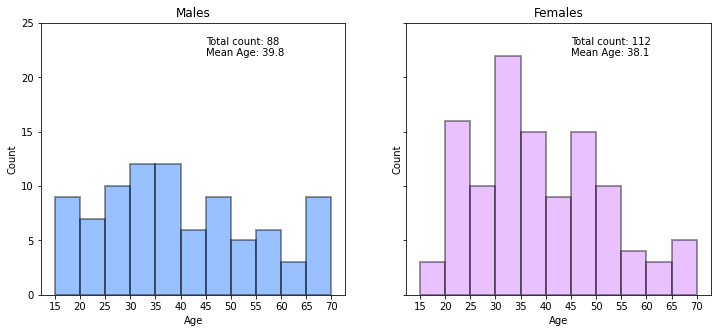

In [7]:
# gender별로 age 나누기
males_age = mall_data[mall_data['Gender']=='Male']['Age']
females_age = mall_data[mall_data['Gender']=='Female']['Age']

age_bins = range(15,75,5)

fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5),sharey=True) # sharey: y축 공유 여부

# males histogram
sns.distplot(males_age,bins=age_bins,kde=False,color='#0066ff',ax=ax1,hist_kws=dict(edgecolor='k',linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23,'Total count: {}'.format(males_age.count()))
ax1.text(45,22,'Mean Age: {:.1f}'.format(males_age.mean()))

# females histogram
sns.distplot(females_age,bins=age_bins,kde=False,color='#cc66ff',ax=ax2,hist_kws=dict(edgecolor='k',linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23,'Total count: {}'.format(females_age.count()))
ax2.text(45,22,'Mean Age: {:.1f}'.format(females_age.mean()))

plt.show()

In [8]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age,females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


- **Kolgomorov-Smirnov test**
      1. 적합도 검정의 대표적인 방법
      2. 누적분포함수 간의 최대 거리를 통계량으로 사용하여 검정
      3. 특징
         1) 연속형 변수에 적용 가능
         2) 필요한 표본의 수가 적음
         3) 모수를 추정할 땐 정확도 낮음

- **분석**
      1. 평균: 남성 > 여성 
      2. 남성의 분포가 여성보다 더 균등함
      3. Kolgomorov-Smirnov를 통해 남녀 간 차이는 통계적으로 무의미함을 뜻함

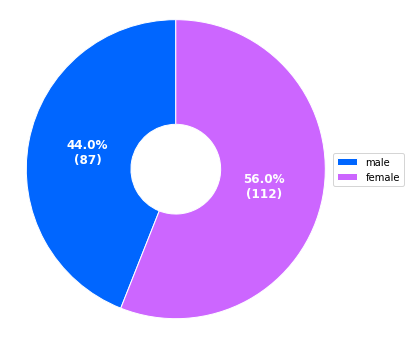

In [9]:
def labeler(pct,allvals):
  absolute = int(pct/100.*np.sum(allvals))
  return '{:.1f}%\n({:d})'.format(pct,absolute)

sizes = [males_age.count(),females_age.count()] 

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges,texts,autotexts = ax1.pie(sizes,autopct=lambda pct: labeler(pct,sizes),radius=1,
                                 colors=['#0066ff','#cc66ff'], startangle=90,textprops=dict(color='w'),
                                 wedgeprops=dict(width=0.7,edgecolor='w'))
ax1.legend(wedges, ['male','female'],loc='center right',bbox_to_anchor=(0.7,0,0.5,1))
plt.setp(autotexts,size=12,weight='bold')
ax1.axis('equal')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


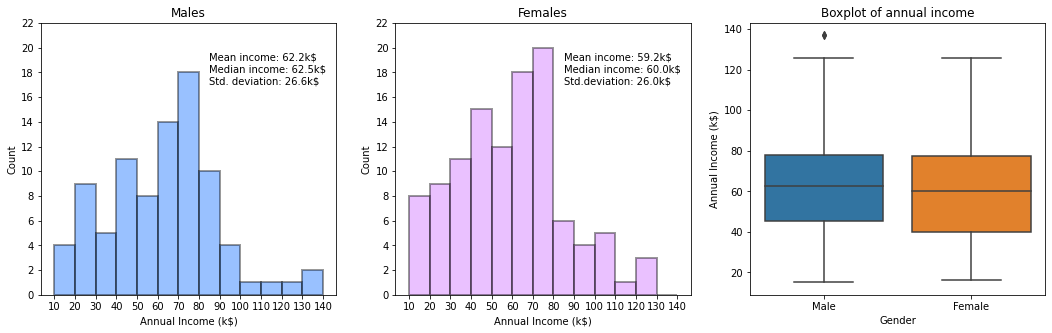

In [10]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)']
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)']

my_bins = range(10,150,10)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))

# males histogram
sns.distplot(males_income,bins=my_bins,kde=False,color='#0066ff',ax=ax1,hist_kws=dict(edgecolor='k',linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19,'Mean income: {:.1f}k$'.format(males_income.mean()))
ax1.text(85,18,'Median income: {:.1f}k$'.format(males_income.median()))
ax1.text(85,17,'Std. deviation: {:.1f}k$'.format(males_income.std()))


# females histogram
sns.distplot(females_income, bins=my_bins, kde=False,color='#cc66ff',ax=ax2,hist_kws=dict(edgecolor='k',linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19,'Mean income: {:.1f}k$'.format(females_income.mean()))
ax2.text(85,18,'Median income: {:.1f}k$'.format(females_income.median()))
ax2.text(85,17,'Std.deviation: {:.1f}k$'.format(females_income.std()))

# boxplot
sns.boxplot(x='Gender',y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [11]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income,females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


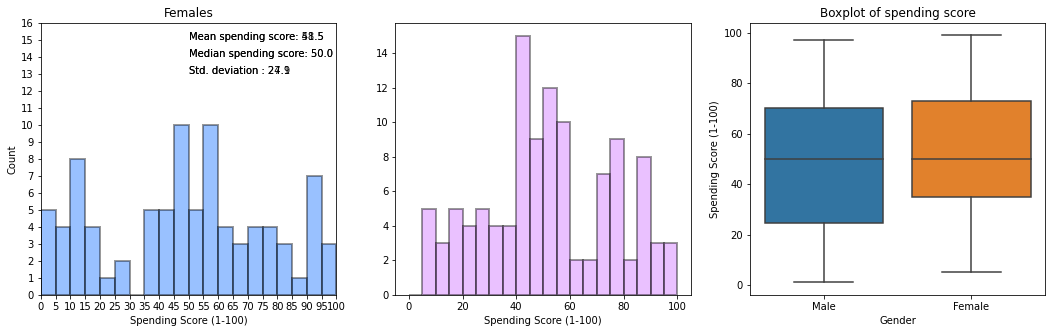

In [12]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)']
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)']

spending_bins = range(0,105,5)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))

# males histogram
sns.distplot(males_spending,bins=spending_bins,kde=False,color='#0066ff',ax=ax1,
             hist_kws=dict(edgecolor='k',linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15,'Mean spending score: {:.1f}'.format(males_spending.mean()))
ax1.text(50,14,'Median spending score: {:.1f}'.format(males_spending.median()))
ax1.text(50,13,'Std. deviation : {:.1f}'.format(males_spending.std()))

# females histogram
sns.distplot(females_spending,bins=spending_bins,kde=False,color='#cc66ff',ax=ax2,
             hist_kws=dict(edgecolor='k',linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Females')
ax1.set_ylabel('Count')
ax1.text(50,15,'Mean spending score: {:.1f}'.format(females_spending.mean()))
ax1.text(50,14,'Median spending score: {:.1f}'.format(females_spending.median()))
ax1.text(50,13,'Std. deviation : {:.1f}'.format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender',y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [13]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending,females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


In [14]:
medians_by_age_group = mall_data.groupby(['Gender',pd.cut(mall_data['Age'],age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender','Age_group'])
medians_by_age_group.reset_index(inplace=True)

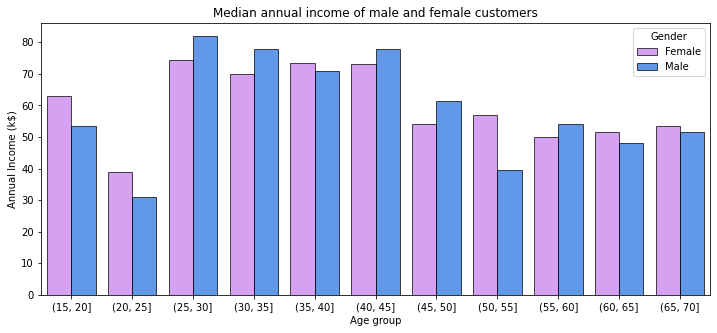

In [15]:
fig,ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group',y='Annual Income (k$)',hue='Gender',
            data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

#### **2) Correlations**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


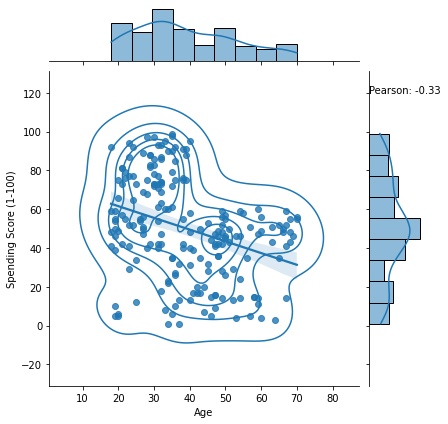

In [16]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr,_ = pearsonr(mall_data['Age'],mall_data['Spending Score (1-100)'])
jp = (sns.jointplot('Age','Spending Score (1-100)',data=mall_data,kind='reg')).plot_joint(sns.kdeplot,zorder=0,n_levels=6)
plt.text(0,120,'Pearson: {:.2f}'.format(corr))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


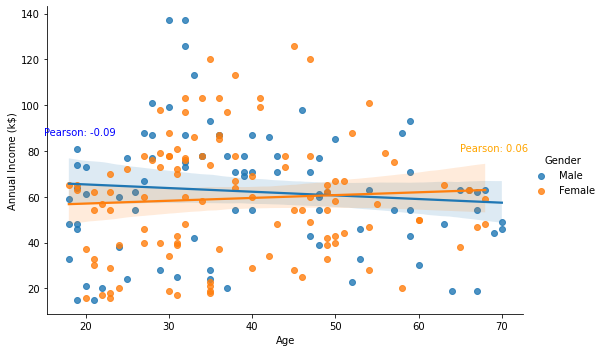

In [17]:
# calculating Pearson's correlations
corr1,_ = pearsonr(males_age.values, males_income.values)
corr2,_ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age','Annual Income (k$)', data=mall_data,hue='Gender',aspect=1.5)
plt.text(15,87,'Pearson: {:.2f}'.format(corr1),color='blue')
plt.text(65,80,'Pearson: {:.2f}'.format(corr2),color='orange')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


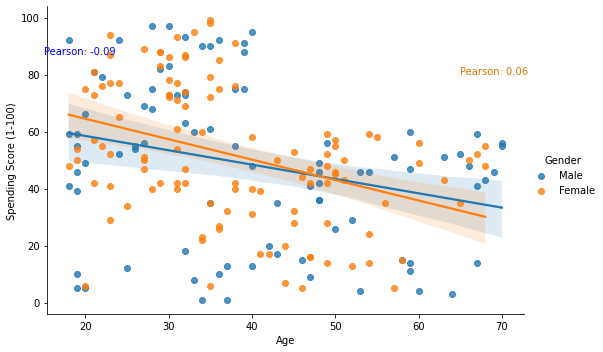

In [18]:
# calculating Pearson's correlations
corr1,_ = pearsonr(males_age.values, males_income.values)
corr2,_ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age','Spending Score (1-100)', data=mall_data,hue='Gender',aspect=1.5)
plt.text(15,87,'Pearson: {:.2f}'.format(corr1),color='blue')
plt.text(65,80,'Pearson: {:.2f}'.format(corr2),color='#d97900')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


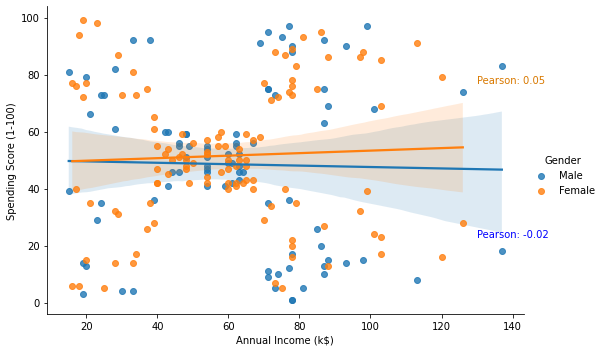

In [19]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

### **4. 군집화 Clustering**
---

#### **4.1.1 Description**

- **3 Main  Steps of K-Means**
      1. seed point를 이용해 샘플을 첫번째 군집으로 split하기 -> seed point에 가장 가까이 있는 샘플들이 첫 군집을 생성할것임
      2. 각 군집의 중심점 사이의 거리를 계산하고 샘플들을 가장 가까이 있는 군집으로 할당하기
      3. 새롭게 형성된 군집의 센트로이드 계산하기
      4. 2번과 3번 단계를 계속 반복하기

#### **4.1.2 Use case - customers segmentation**

In [20]:
from sklearn.cluster import KMeans

In [21]:
X_numerics = mall_data[['Age','Annual Income (k$)', 'Spending Score (1-100)']]

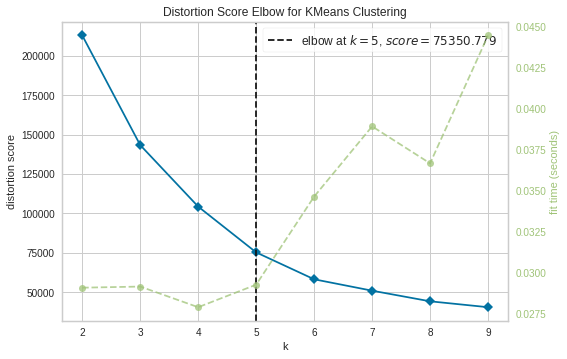

In [22]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model,k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

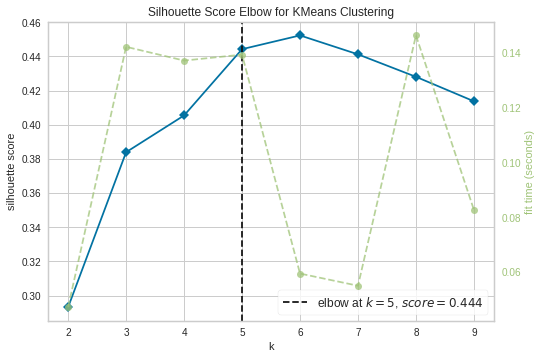

In [23]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model,k=(2,10),metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

In [ ]:
KM_5_clusters = KMeans(n_clusters=5,init='k-means++').fit(X_numerics)
KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


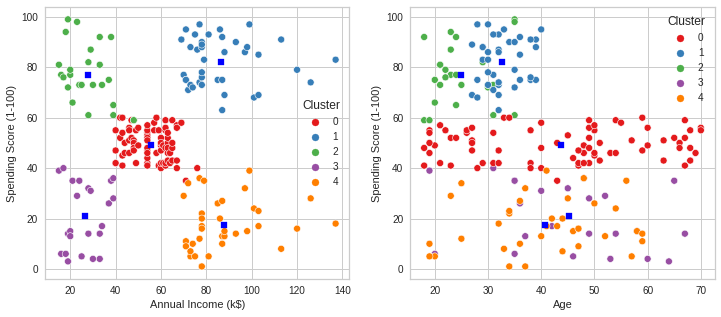

In [ ]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))
scat_1 = sns.scatterplot('Annual Income (k$)','Spending Score (1-100)',data=KM5_clustered,
                         hue='Cluster',ax=axes[0],palette='Set1',legend='full')
sns.scatterplot('Age','Spending Score (1-100)', data=KM5_clustered, hue='Cluster',palette='Set1',
                ax=axes[1],legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2],
                marker='s',s=40,c='blue')
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2],
                marker='s',s=40,c='blue')
plt.show()

In [ ]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ['KM_size']
KM_clust_sizes

,KM_size
Cluster,
0,77
1,39
2,25
3,23
4,36


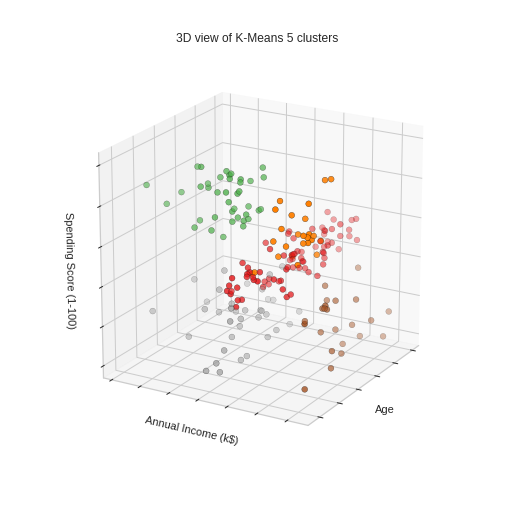

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig,rect=[0,0,0.99,1],elev=20,azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c = KM5_clustered['Cluster'],
           s=35,edgecolor='k',cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [ ]:
import plotly as py
import plotly.graph_objs as go

def tracer(db,n,name):
  return go.Scatter3d(
      x = db[db['Cluster']==n]['Age'],
      y = db[db['Cluster']==n]['Spending Score (1-100)'],
      z = db[db['Cluster']==n]['Annual Income (k$)'],
      mode = 'markers',
      name = name,
      marker = dict(
          size = 5
      )
  )
trace0 = tracer(KM5_clustered,0,'Cluster 0')
trace1 = tracer(KM5_clustered,1,'Cluster 1')
trace2 = tracer(KM5_clustered,2,'Cluster 2')
trace3 = tracer(KM5_clustered,3,'Cluster 3')
trace4 = tracer(KM5_clustered,4,'Cluster 4')

data = [trace0,trace1,trace2,trace3,trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
        xaxis = dict(title = 'Age'),
        yaxis = dict(title = 'Spending Score'),
        zaxis = dict(title = 'Annual Income')
    )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

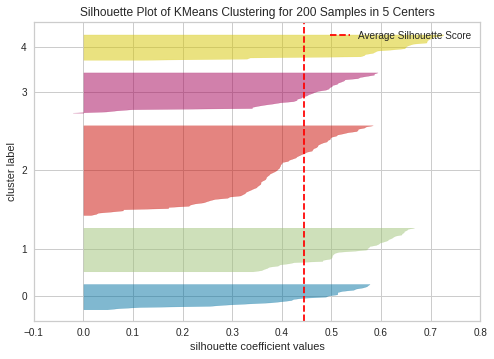

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5,random_state=0)
visualizer = SilhouetteVisualizer(model,colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

In [ ]:
KM_6_clusters = KMeans(n_clusters=6,init='k-means++').fit(X_numerics)
KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



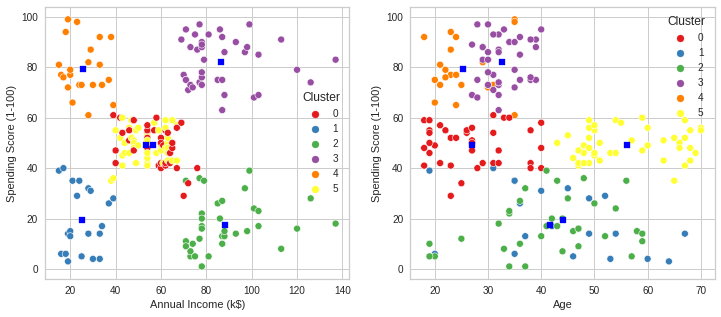

In [ ]:
fig11,(axes) = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot('Annual Income (k$)','Spending Score (1-100)',data=KM6_clustered,hue='Cluster',
                ax=axes[0],palette='Set1',legend='full')
sns.scatterplot('Age','Spending Score (1-100)',data=KM6_clustered,hue='Cluster',
                palette='Set1',ax=axes[1],legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1],KM_6_clusters.cluster_centers_[:,2],marker='s',s=40,c='blue')
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0],KM_6_clusters.cluster_centers_[:,2],marker='s',s=40,c='blue')
plt.show()

In [ ]:
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1],KM_6_clusters.cluster_centers_[:,2],marker='s',s=40,c='blue')
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0],KM_6_clusters.cluster_centers_[:,2],marker='s',s=40,c='blue')
plt.show()

In [ ]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ['KM_size']
KM6_clust_sizes

,KM_size
Cluster,
0,38
1,21
2,35
3,39
4,22
5,45


In [ ]:
trace0 = tracer(KM6_clustered,0,'Cluster 0')
trace1 = tracer(KM6_clustered,1,'Cluster 1')
trace2 = tracer(KM6_clustered,2,'Cluster 2')
trace3 = tracer(KM6_clustered,3,'Cluster 3')
trace4 = tracer(KM6_clustered,4,'Cluster 4')
trace5 = tracer(KM6_clustered,5,'Cluster 5')

data = [trace0,trace1,trace2,trace3,trace4,trace5]

layout = go.Layout(
    title = 'Cluster by K-Means',
    scene = dict(
        xaxis = dict(title = 'Age'),
        yaxis = dict(title = 'Spending Score'),
        zaxis = dict(title = 'Annual Income')
    )
)
fig = go.Figure(data=data,layout=layout)
py.offline.iplot(fig)

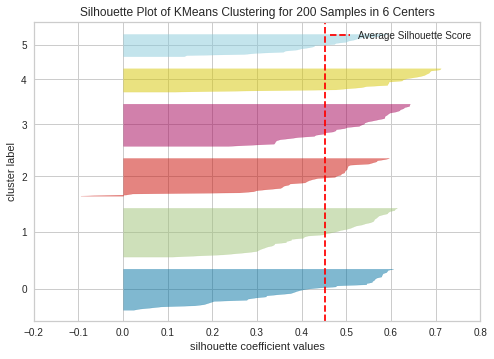

In [ ]:
model = KMeans(n_clusters=6,random_state=0)
visualizer = SilhouetteVisualizer(model,colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

#### **4.2 DBSCAN**

#### **4.2.1 Description**

- **DBSCAN:** **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise
- Two parameters
  - **Eps(ε):** distance
  - **MinPts:** minimum number of points within distance ε

##### **4.2.2 Use case - customers segmentation**

In [24]:
from sklearn.cluster import DBSCAN

In [25]:
from itertools import product

eps_values = np.arange(8,12.75,0.25)
min_samples = np.arange(3,10)
DBSCAN_params = list(product(eps_values,min_samples))

In [26]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
  DBS_clustering = DBSCAN(eps=p[0],min_samples=p[1]).fit(X_numerics)
  no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
  sil_score.append(silhouette_score(X_numerics,DBS_clustering.labels_))

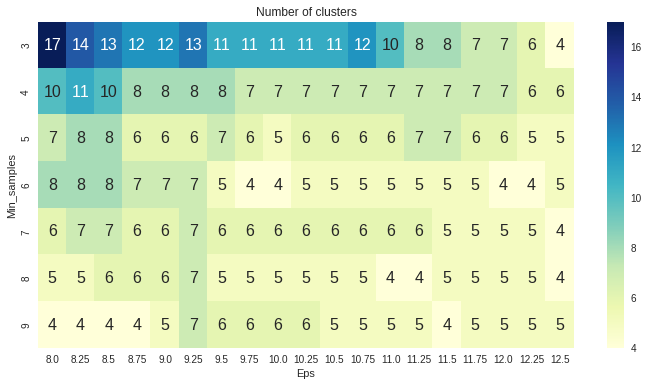

In [27]:
tmp = pd.DataFrame.from_records(DBSCAN_params,columns=['Eps','Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp,values='No_of_clusters',index='Min_samples',columns='Eps')

fig,ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1,annot=True,annot_kws={'size':16},cmap='YlGnBu',ax=ax)
ax.set_title('Number of clusters')
plt.show()

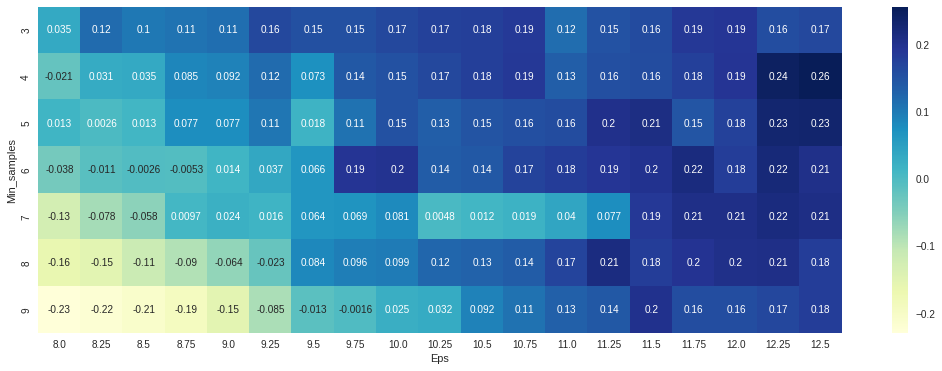

In [28]:
tmp = pd.DataFrame.from_records(DBSCAN_params,columns=['Eps','Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp,values='Sil_score',index='Min_samples',columns='Eps')

fig,ax=plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1,annot=True,annot_kws={'size':10},cmap='YlGnBu',ax=ax)
plt.show()

In [29]:
DBS_clustering = DBSCAN(eps=12.5,min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_

In [ ]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ['DBSCAN_size']
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



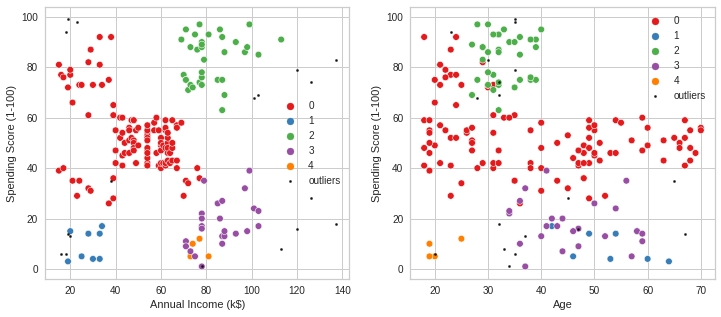

In [ ]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2,(axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)
sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

##### **4.3 Affinity Propagation**

In [ ]:
from sklearn.cluster import AffinityPropagation

In [ ]:
no_of_clusters = []
preferences = range(-20000,-5000,200) 
af_sil_score = [] 

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head()

,preference,clusters,sil_score
41,-11800.0,6.0,0.451649
63,-7400.0,6.0,0.451440
26,-14800.0,6.0,0.451440
46,-10800.0,6.0,0.451440
14,-17200.0,6.0,0.451440


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



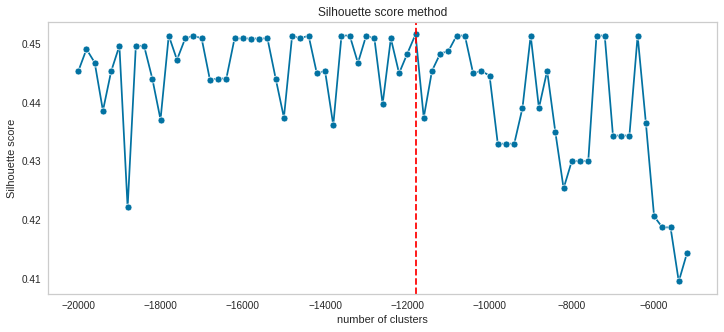

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [ ]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [ ]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_

In [ ]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,11
1,23
2,13
3,44
4,35
5,28
6,24
7,11
8,11


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



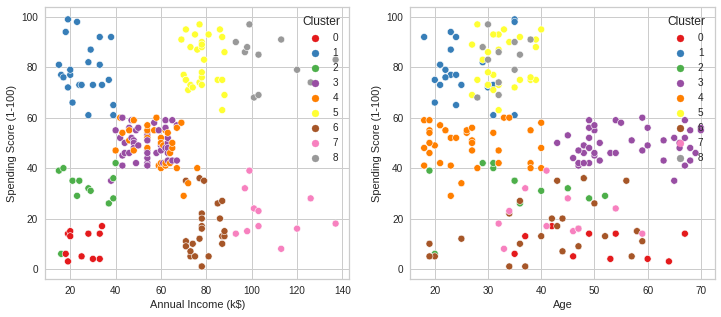

In [ ]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

### **5. Comparison**

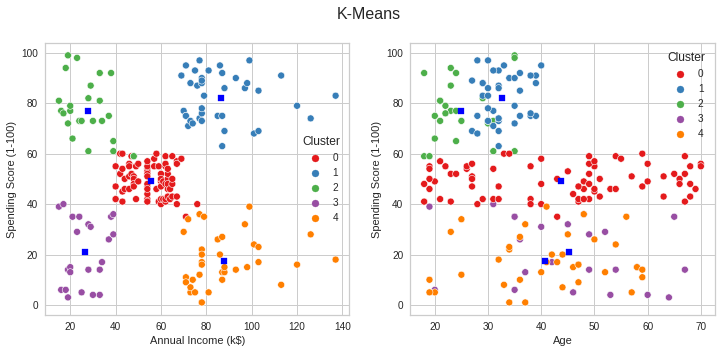

In [ ]:
fig1.suptitle('K-Means', fontsize=16)
fig1

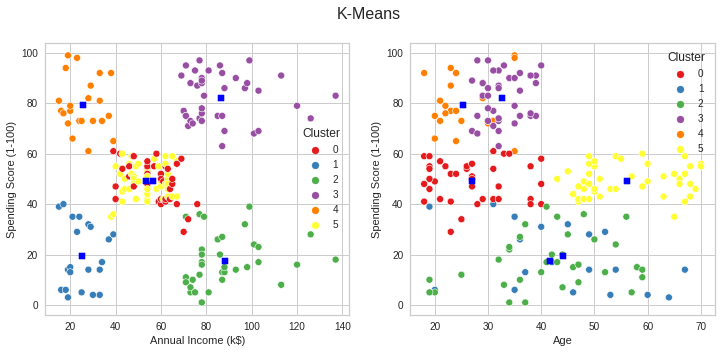

In [ ]:
fig11.suptitle('K-Means', fontsize=16)
fig11

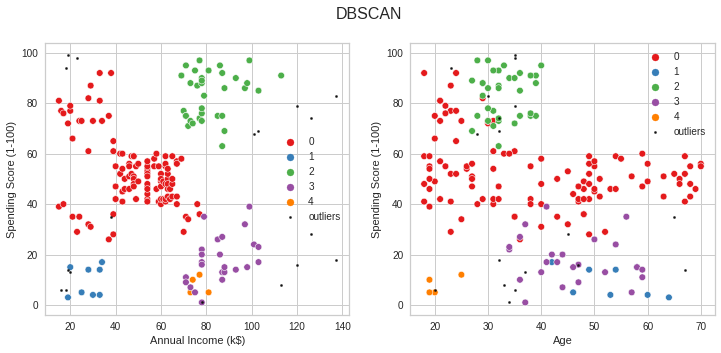

In [ ]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

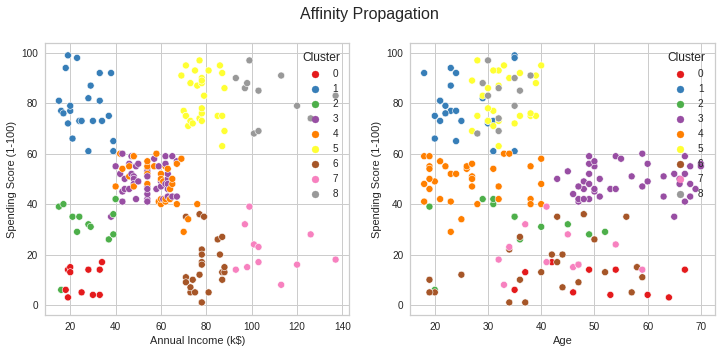

In [ ]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

In [ ]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,38.0,112.0,11.0
1,21.0,8.0,23.0
2,35.0,34.0,13.0
3,39.0,24.0,44.0
4,22.0,4.0,35.0
5,45.0,NaN,28.0
6,NaN,NaN,24.0
7,NaN,NaN,11.0
